# Di-lepton analysis

### Introduction

This notebook is used to process the data stored in [NANOAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) format, and select candidate events of exclusive dilepton production, $pp\to p\oplus\ell\ell\oplus p$, with $\ell\in\{ e,\mu,\tau \} $. Feynman diagram of this process is shown bellow: 

<img src="img/diagrams.png" alt="Feynman diagrams" width="800">



This notebook was prepared based on the [df102_NanoAODDimuonAnalysis.py](https://root.cern.ch/doc/master/group__tutorial__dataframe.html) example from ROOT.

In [1]:
import ROOT
 
# Enable multi-threading
ROOT.ROOT.EnableImplicitMT()

#include auxiliary functions from C++ header
ROOT.gInterpreter.Declare('#include "SelectorTools.h"')

Welcome to JupyROOT 6.24/00


True

### Datasets
`Datasets.py` contains the list of datasets that can be used in the analysis. The `listDatasets()` command will print out the complete list of datasets and also information about samples availability on EOS. 

In [2]:
from Datasets import *
listDatasets()

The following datasets are available:
/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-Pilot_106X_upgrade2018_realistic_v15_L1v1-v2/NANOAODSIM (No directories available in EOS for this dataset)
/DYToMuMu_pomflux_Pt-30_TuneCP5_13TeV-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM (No directories available in EOS for this dataset)
/SingleMuon/Run2017A-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (in EOS: nfiles = 33, size = 56.4GB)
/SingleMuon/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No directories available in EOS for this dataset)
/SingleMuon/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD (No dir

### Analysis

Measurement of exclusive production of lepton pairs rely on two selections:
1. Exclusive cuts - leptons are produced exclusively, i.e., no other particles produced during the proton-proton interaction
2. Correlation between leptons and protons: Due to energy-momentum conservation, the following equation holds:
$ \xi_\pm = \frac{1}{\sqrt{s}}\left[ p_{T,\ell1}\cdot e^{\pm\eta_{\ell1}} + p_{T,\ell2}\cdot e^{\pm\eta_{\ell2}} \right] $, where $\xi$ is proton momentum loss, and $\pm$ sign related to $\xi$ reconstruction of positive/negative proton.

The analysis strategy is to apply selection cuts as in (1) and then plot the difference between $\xi$ reconstructed from leptons and $\xi$ measured by PPS. The events where di-lepton kinematics agree with proton kinematics will be candidates for exclusive dilepton production.

---
Proton content is not available in MC yet, so here we will analyze the data, searching for the correlation between measured $\xi$ from the proton and the predicted $\xi$ based on the lepton kinematics. We are using data available on EOS to speed up the analysis. 

For the example, we will process a small amount of data:

In [3]:
#Select which datasets to use
datasets=[
    'Run2018A_DoubleMuon',
    'Run2018B_DoubleMuon',
    'Run2018C_DoubleMuon',
    'Run2018D_DoubleMuon',
]

In [4]:
#Create a list of files to analyze
for ds in datasets:
    listFiles=getFilesForDataset(ds)
files = ROOT.std.vector("string")(len(listFiles))
for i,f in enumerate(listFiles):
    files[i]=f  
print('found %d files'%len(files))

found 93 files


To read the data we will use [RDataFrame](https://root.cern.ch/doc/master/group__tutorial__dataframe.html) interface to work with nanoAOD trees.

In [5]:
df = ROOT.RDataFrame("Events",files)

In [6]:
#print number of events in the dataframe:
nentries=df.Count()
print("%s entries in the dataframe" %nentries.GetValue())

168417224 entries in the dataframe


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class __pair_base<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


# 1. Exclusive cuts

## Event selection

We will skim the dataframe following event selection of the search for exclusive production of muon pairs ([JHEP07(2018)153](https://arxiv.org/abs/1803.04496))

The following cells contain two selection codes:
1. Preselection: which are contain selection cuts that are usually not used for the optimization
2. Selection cuts: These cuts are optimized and are dependent on the preselection cuts.

In [7]:
def preselect_dimuon(df):
    
    #trigger requirement
    trigger_bits='HLT_IsoMu24'

#    trigger_bits='HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8'
    df = df.Filter(trigger_bits,'Trigger')
    
    #muon selection
    good_mu  = 'Muon_pt>30 && abs(Muon_eta)<2.1' #kinematics
    good_mu += '&& Muon_tightId>0 && abs(Muon_pfRelIso04_all)<0.15' #identification + isolation
#    good_mu += '&& Muon_sip3d<4 && abs(Muon_dxy)<0.5 && abs(Muon_dz)<1.0' #vertex association
    df = df.Define('good_mu',good_mu).Filter('Sum(good_mu)==2','Two good muons')
    
    #save the good-muon related varialbes
    for attr in ['pt','eta','phi','charge','mass']:
        df=df.Define('good_mu_{}'.format(attr),'Muon_{}[good_mu]'.format(attr))
#    df = df.Define("Acoplanarity", "abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))")
#    df = df.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
   
    return df

def select_dimuon(df):
    
    #charge muon1 != charge muon 2
    df = df.Filter('good_mu_charge[0]!=good_mu_charge[1]','OS Muons')
    
    # Acoplanarity cut (back-to-back muons)
    df = df.Define("Acoplanarity", "1-abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))/M_PI")
    df = df.Filter('Acoplanarity<0.009','Acoplanarity')
    
    # Mass cut
    df = df.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
    df = df.Filter('mll>110','mll cut')
    
    # Track selection
    df = df.Filter('nIsoTrack==0','no extra tracks')
       
    return df

In [8]:
#preselection cuts:
df_dimu_presel = preselect_dimuon(df)

In [9]:
# Request cut-flow report
report = df_dimu_presel.Report()
report.Print()

Trigger   : pass=34774621   all=168417224  -- eff=20.65 % cumulative eff=20.65 %
Two good muons: pass=14096842   all=34774621   -- eff=40.54 % cumulative eff=8.37 %


## Pre-selection plots

Before applying analysis cuts here are a few distributions we obtaind from the data:

### acoplanarity

Defined as $A = 1 - |\phi_{\ell,1}-\phi_{\ell,2}|/\pi=1-|\Delta\phi_{\ell\ell}|/\pi$. In exclusive production, both leptons should be back top back in the absence of other particles due to momentum conservation, then $A\sim0$

In [10]:
df_dimu_presel_acopl = df_dimu_presel.Define("Acoplanarity", "1-abs(acos(cos(good_mu_phi[0]-good_mu_phi[1])))/M_PI")

In [11]:
# make histograms
h_acopl = df_dimu_presel_acopl.Histo1D(("Acoplanarity", ";Acoplanarity [rad];N_{Events}", 50, 0, 1), "Acoplanarity")

Info in <TCanvas::Print>: pdf file dimuon_acoplanarity.pdf has been created


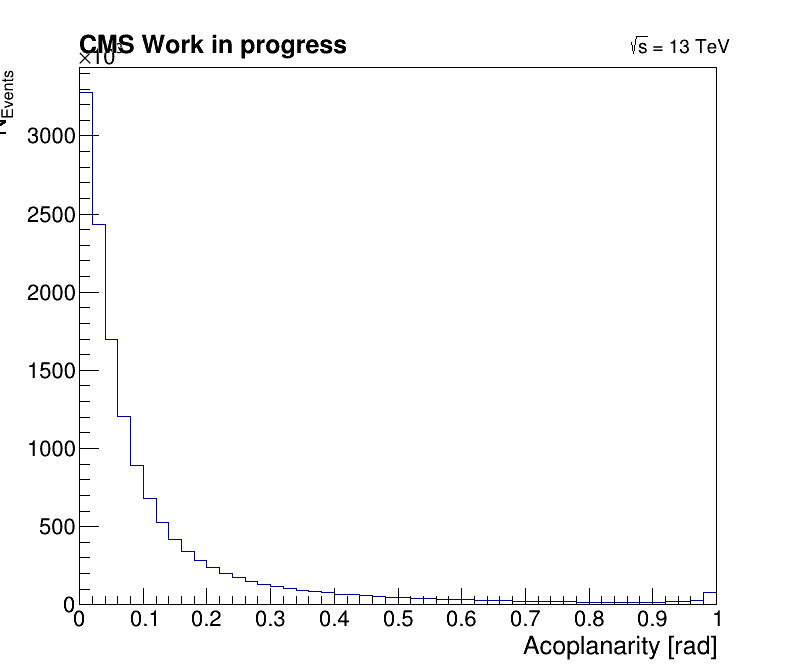

In [12]:
# Produce plots
from Helpers import *
c=PlotMe(h_acopl)
c.Draw()
c.SaveAs("dimuon_acoplanarity.pdf")

### invariant mass

The measurement is performed above the Z mass peak. Invariant mass computed from the two good muons can be obtained using the [ROOT::VecOps::InvariantMass()](https://root.cern/doc/master/group__vecops.html#ga2c531eae910edad48bbf7319cc6d7e58) function

In [13]:
df_dimu_presel_mass = df_dimu_presel.Define("mll", "InvariantMass(good_mu_pt, good_mu_eta, good_mu_phi, good_mu_mass)")
h_mll = df_dimu_presel_mass.Histo1D(("Dimuon_mass", ";m_{#mu#mu} [GeV];N_{Events}", 75, 50, 300), "mll")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file dimuon_spectrum.pdf has been created


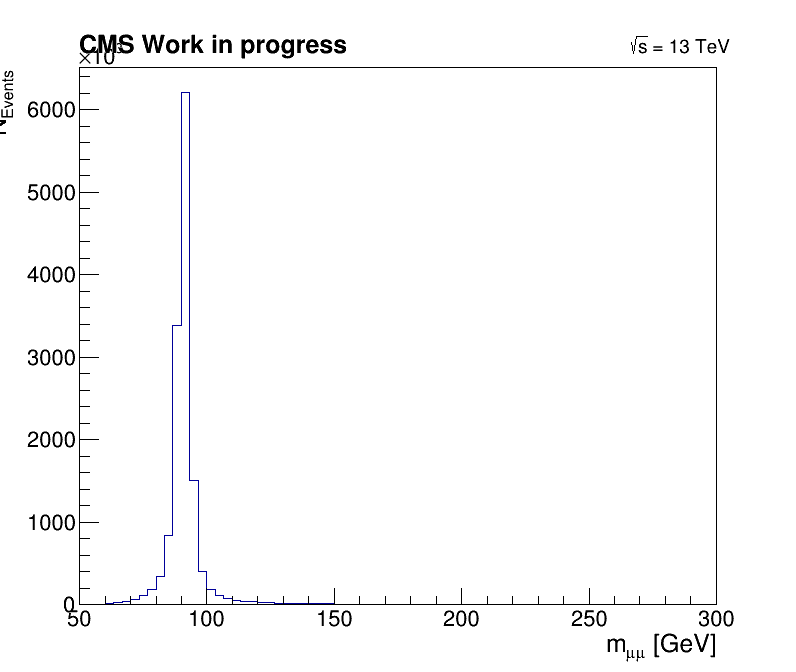

In [14]:
# Produce plots
c=PlotMe(h_mll)
c.Draw()
c.SaveAs("dimuon_spectrum.pdf")

# Final event selection

Based on analysis of signal and background distributions obtained in the previous step, final analysis cuts are selected and applied to the dataset

In [15]:
#event selection:
df_dimu_sel = select_dimuon(df_dimu_presel)

In [16]:
# Request cut-flow report
report = df_dimu_sel.Report()
report.Print()

Trigger   : pass=34774621   all=168417224  -- eff=20.65 % cumulative eff=20.65 %
Two good muons: pass=14096842   all=34774621   -- eff=40.54 % cumulative eff=8.37 %
OS Muons  : pass=14092669   all=14096842   -- eff=99.97 % cumulative eff=8.37 %
Acoplanarity: pass=1560398    all=14092669   -- eff=11.07 % cumulative eff=0.93 %
mll cut   : pass=51818      all=1560398    -- eff=3.32 % cumulative eff=0.03 %
no extra tracks: pass=34422      all=51818      -- eff=66.43 % cumulative eff=0.02 %


## Snapshot (saving reduced ntuples for further analysis)

In order to proceed with the analysis, we will skim/slim the sample and store the smaller sub-sample in our local EOS space.
- skimming: selecting sub-sample of events that pass all filters
- slimming: keeping only relevant brunches (columns)

This is done using the [Snapshot()](https://root.cern/doc/master/df007__snapshot_8py.html) function

---
It might be more convenient to save snapshots for a small dataset, then [hadd](https://root.cern/doc/master/hadd_8cxx.html) the files (otherwise it takes too long)

In [17]:
#using regular expression to define needed columns:
branchList='('
branchList+='^mll$|'
branchList+='^Acoplanarity$|'
branchList+='^.*good_mu_.*$|'
branchList+='^nProton_multiRP$|'
branchList+='^.*Proton_multiRP_.*$'
branchList+=')'

In [18]:
#save the snapshot
import time
PATH='.'
tic=time.time()
df_dimu_sel.Snapshot('Events',PATH+'/df_dimu_sel.root',branchList)
print('Creating the snapshot took %2.2f sec' % ((time.time()-tic)))

Creating the snapshot took 1754.20 sec


In [19]:
#check the new filesize:
print('output filesize = %s'%(PrintFileSize(os.path.getsize(PATH+'/df_dimu_sel.root')) ))

output filesize = 2.32MB


In [20]:
#check the file content:
f1 = ROOT.TFile(PATH+'/df_dimu_sel.root')
t = f1.Events
print("These are the columns:")
for branch in t.GetListOfBranches():
    print("Branch: %s" %branch.GetName())
f1.Close()

These are the columns:
Branch: good_mu_pt
Branch: good_mu_eta
Branch: good_mu_phi
Branch: good_mu_charge
Branch: good_mu_mass
Branch: nProton_multiRP
Branch: Proton_multiRP_t
Branch: Proton_multiRP_thetaX
Branch: Proton_multiRP_thetaY
Branch: Proton_multiRP_time
Branch: Proton_multiRP_timeUnc
Branch: Proton_multiRP_xi
Branch: Proton_multiRP_arm


### Next time you start - start from here

import relevant modules, and load the snapshot for future studies

In [21]:
#import ROOT
#ROOT.ROOT.EnableImplicitMT()
#ROOT.gInterpreter.Declare('#include "SelectorTools.h"')
#from Datasets import *
#from Helpers import *

PATH='.'
df_dimu_sel = ROOT.RDataFrame("Events",PATH+'/df_dimu_sel.root')

# 2. Correlation between leptons and protons

## Tagged protons selection

Once events with exclusive signature have been selected, correlation between the proton kimenatics and lepton kinematics is tested. In exclusive production where leptons and protons have the same origin, full correlation will be observed.

Before starting with the analysis, we will select events with good tagged protons and central event kinematics (di-$\ell$) which predict a proton within the acceptance of the PPS.

### PPS acceptance:

We will extract the acceptance of PPS detectors

In [22]:
def select_proton_pos(df):
    
    #recontruct xi from di-lepton
    df = df.Define("xi0_ll", "Sum(good_mu_pt*exp(+good_mu_eta))/13000.")
    
    #proton selection
    df = df.Define('xi_pr0','SelectProtonXi(Proton_multiRP_xi,Proton_multiRP_arm,xi0_ll,0)').Filter('xi_pr0>0','proton in the positive arm') # proton in positive direction (+z)
    
    return df

def select_proton_neg(df):
    
    #recontruct xi from di-lepton
    df = df.Define("xi1_ll", "Sum(good_mu_pt*exp(-good_mu_eta))/13000.")

    #proton selection
    df = df.Define('xi_pr1','SelectProtonXi(Proton_multiRP_xi,Proton_multiRP_arm,xi1_ll,1)').Filter('xi_pr1>0','proton in the negative arm') # proton in negative direction (-z)
    
    return df

In [23]:
df_dimu_sel_pro0 = select_proton_pos(df_dimu_sel)

minVal0 = df_dimu_sel_pro0.Min('xi_pr0')
maxVal0 = df_dimu_sel_pro0.Max('xi_pr0')
print("Positive arm acceptance:%s <= xi <= %s" %(minVal0.GetValue(), maxVal0.GetValue()))
 

Positive arm acceptance:0.0203857421875 <= xi <= 0.203765869140625


In [24]:
#filter events with reconstructed xi from di-lep is outside PPS acceptance
#df_dimu_sel_pro0_withll = df_dimu_sel_pro0.Filter('xi0_ll>%s && xi0_ll<%s'%(minVal0.GetValue(), maxVal0.GetValue()),'dilep predict a proton in +z')
df_dimu_sel_pro0_withll = df_dimu_sel_pro0.Filter('xi0_ll>%s && xi0_ll<%s'%(0.04, maxVal0.GetValue()),'dilep predict a proton in +z')

In [25]:
report = df_dimu_sel_pro0_withll.Report()
report.Print()

proton in the positive arm: pass=14796      all=34422      -- eff=42.98 % cumulative eff=42.98 %
dilep predict a proton in +z: pass=1860       all=14796      -- eff=12.57 % cumulative eff=5.40 %


In [26]:
df_dimu_sel_pro1 = select_proton_neg(df_dimu_sel)

minVal1 = df_dimu_sel_pro1.Min('xi_pr1')
maxVal1 = df_dimu_sel_pro1.Max('xi_pr1')
print("Negative arm acceptance:%s <= xi <= %s" %(minVal1.GetValue(), maxVal1.GetValue()))
 

Negative arm acceptance:0.022724151611328125 <= xi <= 0.2752685546875


In [27]:
#filter events with reconstructed xi from di-lep is outside PPS acceptance
#df_dimu_sel_pro1_withll = df_dimu_sel_pro1.Filter('xi1_ll>%s && xi1_ll<%s'%(minVal1.GetValue(), maxVal1.GetValue()),'dilep predict a proton in -z')
df_dimu_sel_pro1_withll = df_dimu_sel_pro1.Filter('xi1_ll>%s && xi1_ll<%s'%(0.04, maxVal1.GetValue()),'dilep predict a proton in -z')

In [28]:
report = df_dimu_sel_pro1_withll.Report()
report.Print()

proton in the negative arm: pass=15420      all=34422      -- eff=44.80 % cumulative eff=44.80 %
dilep predict a proton in -z: pass=1946       all=15420      -- eff=12.62 % cumulative eff=5.65 %


Once the PPS acceptance is extracted, and we selected events where two-lepton kinematics suggest a proton within the PPS detector, we can inspect correlations.

In [29]:
df_dimu_sel_pro0_withll_delXi = df_dimu_sel_pro0_withll.Define('DelXi','xi0_ll-xi_pr0')
h_xi0 = df_dimu_sel_pro0_withll_delXi.Histo1D(("Delta_xi0", ";#xi_{ll}-#xi_{p+};N_{Events}", 100, -0.1, 0.1), "DelXi")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file correlation_positive_arm.pdf has been created


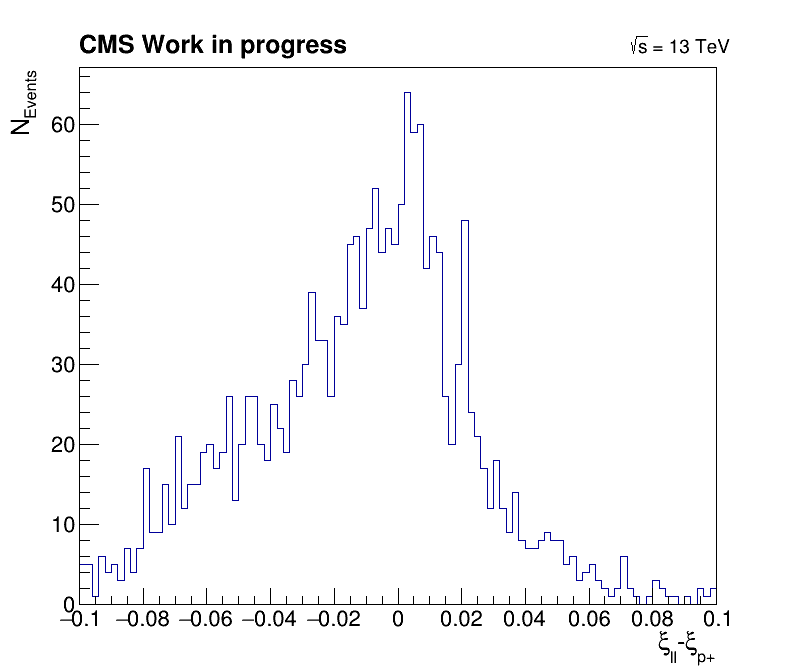

In [30]:
# Produce plots
c=PlotMe(h_xi0)
c.Draw()
c.SaveAs("correlation_positive_arm.pdf")

In [31]:
df_dimu_sel_pro1_withll_delXi = df_dimu_sel_pro1_withll.Define('DelXi','xi1_ll-xi_pr1')
h_xi1 = df_dimu_sel_pro1_withll_delXi.Histo1D(("Delta_xi1", ";#xi_{ll}-#xi_{p-};N_{Events}", 100, -0.1, 0.1), "DelXi")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file correlation_negative_arm.pdf has been created


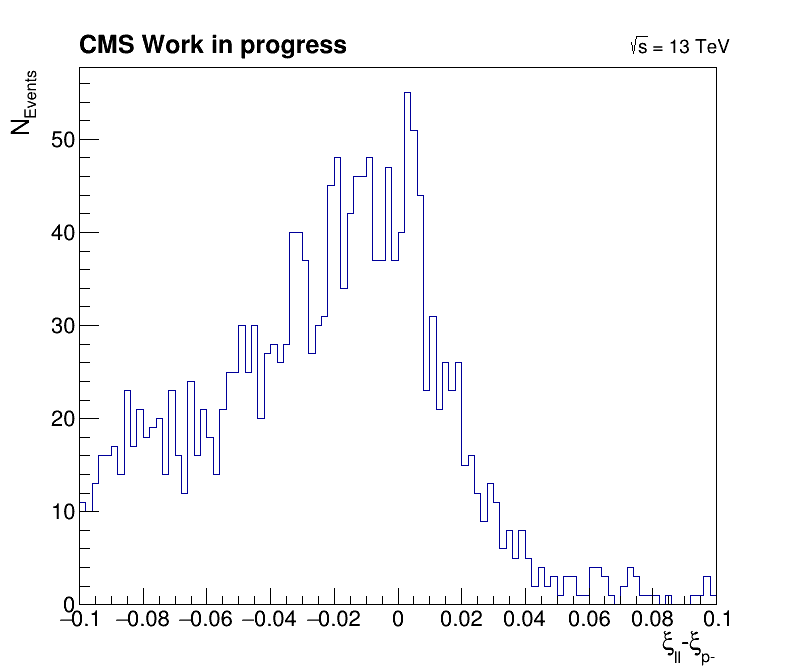

In [32]:
 # Produce plots
c=PlotMe(h_xi1)
c.Draw()
c.SaveAs("correlation_negative_arm.pdf")

In [33]:
h_xi1_2D = df_dimu_sel_pro1_withll.Histo2D(("negXi_2D", ";#xi_{ll};#xi_{pp}", 64, 0., 0.2, 32, 0., 0.2), "xi1_ll", "xi_pr1");

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file correlation_negative_arm_2D.pdf has been created


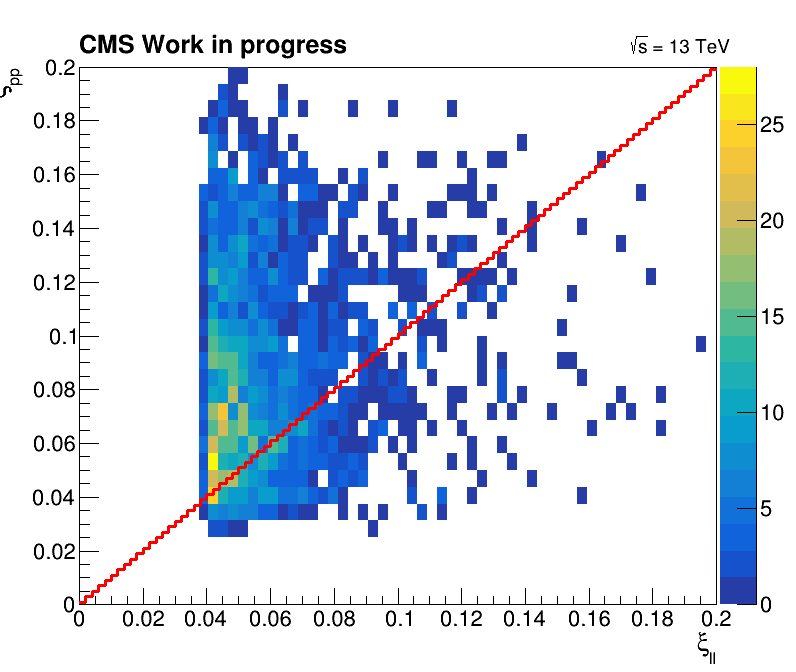

In [34]:
 # Produce plots
c=PlotMe(h_xi1_2D,'colz')
c.Draw('colz') 
line=ROOT.TF1('line','x',0,0.2)
line.SetLineWidth(3); line.Draw('sames')
c.SaveAs("correlation_negative_arm_2D.pdf")